In [207]:
from astropy.table import Table
from matplotlib import pyplot as plt
from numpy.random import random
import numpy as np
from scipy.stats import kde
from scipy.optimize import curve_fit
%matplotlib inline

In [276]:
d = Table.read('03071_magerr.txt', format='ascii')
d['col5'] *= -1

Fotran code.
mag_th = mag_t

# Exponential part
    if (mag_th .le. 21.d0) then
       magerr = mag_er(1)
    else if (mag_th .le. mag_er(3)) then
       magerr = mag_er(1)*10.d0**(mag_er(2)*(mag_th-21.d0))
    else
       magerr = max(mag_er(1)*10.d0**(mag_er(2)*(mag_er(3)-21.d0)) &
            - (mag_th - mag_er(3))*mag_er(4), 0.d0)
    end if
    
!    call dgauss(seed, tmp)
    tmp = ran3(seed)
    if (tmp .le. 0.5) then
       tmp = sqrt(6.d0)*(sqrt(2.d0*tmp) - 1.d0)
    else
       tmp = sqrt(6.d0)*(1.d0 - sqrt(2.d0*(1.d0-tmp)))
    end if
    mag = mag_th + magerr*tmp
    
# Offset Part
    if (mag_th .gt. mag_er(5)) then
       mag = mag + (mag_th - mag_er(5))*mag_er(6)
    end if


In [277]:
def sigma(mag, p1=0.005, p2=0.22, p3=26.2, p4=-0.09, bright=22):
    sigma = p1*10**(p2*(p3-bright)) - (mag - p3)*p4
    sigma[sigma < 0] = 0
    sigma[mag < p3] = p1*10**(p2*(mag[mag < p3]-bright))
    sigma[mag < bright] = p1
    return sigma
def offset(mag, p5=22, p6=0.015):
    offset = 0*mag
    offset[mag>p5] = (mag[mag > p5] - p5)*p6
    return offset

In [278]:
def magran(mag, p1=0.05, p2=0.22, p3=26.2, p4=-0.09, p5=22, p6=0.015):
    s6 = 6**0.5
    _sigma = sigma(mag, p1, p2, p3, p4)
    r = random(len(mag))
    s1 = s6*((2*r)**0.5 - 1.0)
    s2 = s6*(1.0 - (2*(1-r))**0.5)
    r[r<=0.5] = s1[r<=0.5]
    r[r>0.5] = s2[r>0.5]    
    mag_out = mag + _sigma*r
    mag_out += offset(mag, p5, p6)
    return mag_out

[ 1.22623014e-02  2.82882076e-01  3.29221445e+01 -2.40499997e-01]
[ 2.17581806e+01 -1.13307692e-02]


/Users/kavelaarsj/.pyenv/versions/3.9.1/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


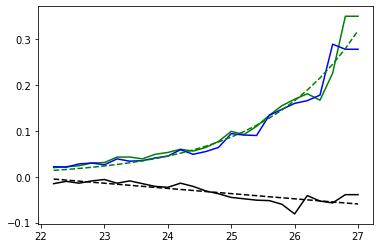

In [280]:
fig, ax = plt.subplots(facecolor='w')
ax.plot(d['col1'], d['col4'], '-g')
ax.plot(d['col1'], d['col3'], '-b')
ax.plot(d['col1'], d['col5'], '-k')

x=d['col1']
y=(d['col4']+d['col3'])/2

p0=[0.02, 0.22, 26.2, -0.09]

params1, cov1 = curve_fit(sigma, x, y, p0=p0)
print(params1)
_sigma = sigma(d['col1'], p1=params1[0], p2=params1[1], p3=params1[2], p4=params1[3])
ax.plot(x, _sigma, '--g')

y=d['col5']
params2, cov2 = curve_fit(offset, x, y, [22, 0.15])
_offset = offset(d['col1'], p5=params2[0], p6=params2[1])
print(params2)
ax.plot(d['col1'], _offset, '--k')

In [281]:
params = np.append(params1, params2)
print(params)

[ 1.22623014e-02  2.82882076e-01  3.29221445e+01 -2.40499997e-01
  2.17581806e+01 -1.13307692e-02]


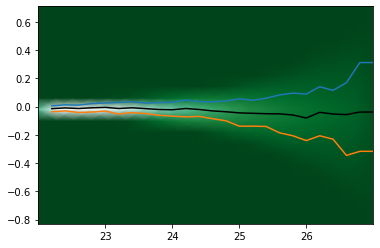

In [282]:
m = magran(mags, params1[0], params1[1], params1[2], params1[3], params2[0], params2[1])
x = mags
y = m-mags
nbins = 20
k = kde.gaussian_kde([x, y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
fig, ax = plt.subplots(facecolor='w')
ax.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.BuGn_r)
#plt.plot(mags, m-mags, '.')
#plt.plot(mags, m-mags, '.')
ax.plot(d['col1'], d['col4']+d['col5'], '-')
ax.plot(d['col1'], -d['col3']+d['col5'], '-')
ax.plot(d['col1'], d['col5'], '-k')

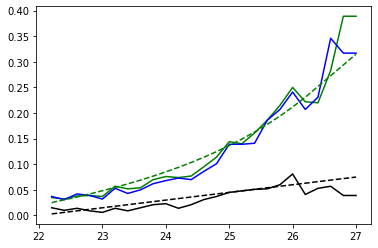